# Eğitilmiş Modeli Web Service Olarak Yayınlamak
* **1_MNIST_ModelTraining.ipynb** egzersini yap veya pkl dosyasını arayüzden register et.
* Eğitilmiş modeli indir.
* Localde test et.
* Bulutta Container oluştur.
* Web Service olarak yayınla

In [2]:
import azureml.core
from azureml.core import Workspace

print('SDK versiyonu', azureml.core.VERSION)

SDK versiyonu 1.27.0


In [5]:
!ls

1_MNIST_ModelTraining.ipynb		      config.json
1_mnist_modeltraining.ipynb.amltmp	      mnist_data
2_MNIST_TrainedModel_WebService.ipynb	      mnist_script
2_mnist_trainedmodel_webservice.ipynb.amltmp  sklearn_mnist_trained_model.pkl


## Localde Eğitilmiş Modeli Test Edelim

### Test veriyi hazırlayalım

In [10]:
#module bulamazsa notebook yeniden başlatmak gerekli.
from mnist_script.yardimci import veri_uncompress

test_images_path='./mnist_data/test-images.gz'
test_labels_path='./mnist_data/test-labels.gz'

X_test = veri_uncompress(test_images_path, False) / 255.0
y_test = veri_uncompress(test_labels_path, True).reshape(-1)

# (satır,kolon)
print(f"Train : {X_test.shape} | Test : {y_test.shape}")

Train : (10000, 784) | Test : (10000,)


### Tahmin

In [16]:
import joblib

clf = joblib.load('./trained_model/sklearn_mnist_trained_model.pkl')
y_test_tahmin = clf.predict(X_test)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix


conf_mx = confusion_matrix(y_test, y_test_tahmin)

print("Not: X ekseninde gerçek değerler. Y Ekseninde tahminler yer alır.\n")
print(conf_mx)
print('\nOverall accuracy:', np.average(y_test_tahmin == y_test))

Not: X ekseninde gerçek değerler. Y Ekseninde tahminler yer alır.

[[ 960    0    1    2    1    5    6    3    1    1]
 [   0 1112    3    1    0    1    5    1   12    0]
 [   9    8  920   20   10    4   10   11   37    3]
 [   4    0   17  921    2   21    4   12   20    9]
 [   1    2    4    3  916    0   10    2    6   38]
 [  10    2    0   41   10  770   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    7   22    5    8    1    1  950    5   27]
 [  10   15    5   21   15   27    7   11  851   12]
 [   7    8    2   13   32   13    0   24   12  898]]

Overall accuracy: 0.9205


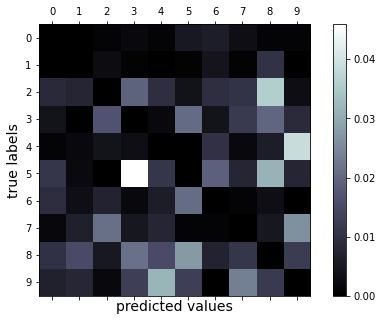

In [25]:
#confusion matrixi renklendirelim. Köşegen 0 yani siyah olsun. Geri kalan hata arttıkça beyaz olsun.
import matplotlib.pyplot as plt

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums #normalleşmiş matrixi elde ediyoruz.

np.fill_diagonal(norm_conf_mx, 0) #köşegen siyah olacak.

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)

plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)

plt.savefig('conf.png')
plt.show()

## Register Edilen Modelleri Listeleyelim

In [55]:
ws = Workspace.from_config()

print(f'Workspace: {ws.name} | Rg: {ws.resource_group} | Location: {ws.location}')

Workspace: kisemlws | Rg: krg | Location: northeurope


In [56]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

sklearn_mnist version: 1




In [57]:
model = ws.models['sklearn_mnist']
print(model.name, 'version', model.version)

sklearn_mnist version 1


## Web Service Deploy Edelim
* run ve init fonksiyonları olan ve scorelama(tahminleme) yapan script dosyası
* içerisinde imagein konfigurasyonun bulunan yml dosyası
* Azure Container Instance veya Azure Kubernetes Services Compute

### Score dosyası

In [40]:
import os

ws_yayin='ws_yayin'
os.makedirs(ws_yayin,exist_ok = True)

In [58]:
%%writefile $ws_yayin/score.py
import numpy as np
import json
import joblib
from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('sklearn_mnist')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Overwriting ws_yayin/score.py


### Environment

In [60]:
from azureml.core.conda_dependencies import CondaDependencies 

# Add the dependencies for our model (AzureML defaults is already included)
myenv = CondaDependencies()
myenv.add_conda_package('scikit-learn')

# Save the environment config as a .yml file
env_file = os.path.join(ws_yayin,"mnist_env.yml")

with open(env_file,"w") as f:
    f.write(myenv.serialize_to_string())

print("Saved dependency info in", env_file)

# Print the .yml file
with open(env_file,"r") as f:
    print(f.read())

Saved dependency info in ws_yayin/mnist_env.yml
# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

- scikit-learn
channels:
- anaconda
- conda-forge



### ACI configurasyonu

In [61]:
#Azure Container Instance (Ayrıca Compute kısmında görünmez. Webservice deploy edilinci tümü Endpoint kısmında olur)
from azureml.core.webservice import AciWebservice

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)

In [63]:
from azureml.core.model import InferenceConfig

# Configure the scoring environment
inference_config = InferenceConfig(runtime= "python",
                                   entry_script=ws_yayin+'/score.py',
                                   conda_file=env_file)

### Web Service Deploy

In [67]:
service = Model.deploy(ws,'mnist-ws', [model], inference_config, deployment_config)

service.wait_for_deployment(True)
print(service.state)

In [72]:
#print(service.get_logs())
print(service.scoring_uri)

http://19b807e7-d785-4391-aa3c-da9a99125067.northeurope.azurecontainer.io/score


In [71]:
for webservice_name in ws.webservices:
    print(webservice_name)

mnist-ws


### Web Service Kullanalım

#### SDK ile

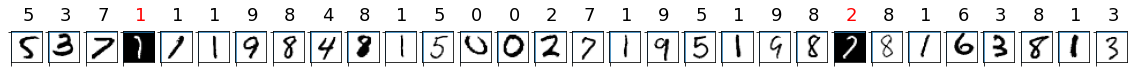

In [74]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

#### HTTP Request ile

label: 7
prediction: [7]


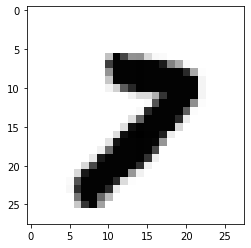

In [151]:
import requests
import json

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

#print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

#resme bakalım
plt.imshow(X_test[random_index].reshape(28, 28), cmap=clr_map)
plt.show()

### Service silmek

In [ ]:
#service silmek için
#service.delete()